In [2]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [3]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [4]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
    iterations_to_analyze = range(1, n_iterations, 100)
    print(list(iterations_to_analyze)) # check that this is giving me the last avail iteration
    for step in iterations_to_analyze: 
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    print("Neff: ", analyzer.mbar.computeEffectiveSampleNumber())
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/11)

In [5]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [6]:
main_dir = 32
sub_dir = 3
chunk = 11
titles = ['ALA->THR']

In [7]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical ineffic

DEBUG:openmmtools.multistate.multistateanalyzer:  10.944  10.944  12.480  13.922  14.195  13.049  10.359   6.042   0.000  -7.901 -17.727 -29.440
DEBUG:openmmtools.multistate.multistateanalyzer:  18.845  18.845  20.382  21.823  22.097  20.951  18.261  13.943   7.901   0.000  -9.825 -21.539
DEBUG:openmmtools.multistate.multistateanalyzer:  28.670  28.670  30.207  31.649  31.922  30.776  28.086  23.769  17.727   9.825   0.000 -11.713
DEBUG:openmmtools.multistate.multistateanalyzer:  40.384  40.384  41.920  43.362  43.635  42.490  39.799  35.482  29.440  21.539  11.713   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.071   0.118   0.165   0.209   0.247   0.277   0.304   0.330   0.353   0.375
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.071   0.118   0.165   0.209   0.247   0.277   0.304   0.330   0.353   0.375
DEBUG:openmmtools.multistate.multistateanalyzer:   0.071   0.071   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to

DEBUG:openmmtools.multistate.multistateanalyzer:   4.962   4.962   6.430   7.782   7.951   6.782   4.166   0.000  -5.881 -13.663 -23.424 -35.087
DEBUG:openmmtools.multistate.multistateanalyzer:  10.843  10.843  12.311  13.664  13.833  12.664  10.048   5.881   0.000  -7.781 -17.543 -29.205
DEBUG:openmmtools.multistate.multistateanalyzer:  18.624  18.624  20.092  21.445  21.614  20.445  17.829  13.663   7.781   0.000  -9.762 -21.424
DEBUG:openmmtools.multistate.multistateanalyzer:  28.386  28.386  29.854  31.206  31.376  30.207  27.591  23.424  17.543   9.762   0.000 -11.663
DEBUG:openmmtools.multistate.multistateanalyzer:  40.048  40.048  41.517  42.869  43.038  41.869  39.253  35.087  29.205  21.424  11.663   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.041   0.069   0.093   0.114   0.133   0.151   0.168   0.184   0.197   0.209
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:   0.699   0.699   2.116   3.468   3.688   2.567   0.000  -4.125  -9.967 -17.696 -27.398 -38.992
DEBUG:openmmtools.multistate.multistateanalyzer:   4.824   4.824   6.241   7.593   7.813   6.692   4.125   0.000  -5.842 -13.571 -23.272 -34.867
DEBUG:openmmtools.multistate.multistateanalyzer:  10.667  10.667  12.083  13.435  13.655  12.534   9.967   5.842   0.000  -7.728 -17.430 -29.025
DEBUG:openmmtools.multistate.multistateanalyzer:  18.395  18.395  19.811  21.163  21.384  20.263  17.696  13.571   7.728   0.000  -9.702 -21.297
DEBUG:openmmtools.multistate.multistateanalyzer:  28.097  28.097  29.513  30.865  31.086  29.965  27.398  23.272  17.430   9.702   0.000 -11.595
DEBUG:openmmtools.multistate.multistateanalyzer:  39.692  39.692  41.108  42.460  42.680  41.559  38.992  34.867  29.025  21.297  11.595   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:  -1.813  -1.813  -0.433   0.912   1.105   0.000  -2.541  -6.676 -12.531 -20.241 -29.910 -41.499
DEBUG:openmmtools.multistate.multistateanalyzer:   0.728   0.728   2.108   3.453   3.646   2.541   0.000  -4.135  -9.990 -17.700 -27.368 -38.958
DEBUG:openmmtools.multistate.multistateanalyzer:   4.863   4.863   6.242   7.588   7.780   6.676   4.135   0.000  -5.855 -13.565 -23.234 -34.824
DEBUG:openmmtools.multistate.multistateanalyzer:  10.718  10.718  12.098  13.443  13.636  12.531   9.990   5.855   0.000  -7.710 -17.378 -28.968
DEBUG:openmmtools.multistate.multistateanalyzer:  18.428  18.428  19.807  21.153  21.345  20.241  17.700  13.565   7.710   0.000  -9.669 -21.259
DEBUG:openmmtools.multistate.multistateanalyzer:  28.096  28.096  29.476  30.822  31.014  29.910  27.368  23.234  17.378   9.669   0.000 -11.590
DEBUG:openmmtools.multistate.multistateanalyzer:  39.686  39.686  41.066  42.412  42.604  41.499  38.958  34.824  28.968  21.259  

Neff:  [ 942.63434613  942.63434613 1252.68538116 1285.60702145 1232.42529912
 1205.88809235 1198.63108508 1197.36783955 1210.11943195 1191.22879754
  987.76618229  635.48511026]


In [8]:
apo_dg

array([-41.68079064, -40.38359695, -39.66423092, -39.54644273,
       -40.04821081, -39.96491959, -39.33865009, -39.6915149 ,
       -39.63171788, -39.40257484, -39.68640838])

In [9]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


11 apo: -39.68640838494703 (0.13567998280885296) kT



In [10]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) 

<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/14)

In [34]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [35]:
main_dir = 32
sub_dir = 3
chunk = 14
titles = ['ALA->THR']

In [36]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [ 968.09334734  968.09334734 1247.77170262 1198.44754564 1137.41172023
 1205.5723835  1082.74409193 1075.88363512 1205.04607182 1084.02073335
  940.63368794  556.01519063]


In [37]:
apo_dg

array([-47.3177203 , -43.37218716, -43.35641656, -43.62999496,
       -43.51905877, -44.18810086, -44.0729309 , -44.29511314,
       -43.9166326 , -44.20404716, -44.06659209])

In [38]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


14 apo: -44.06659208782158 (0.15451317250114188) kT



In [39]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/15)

In [40]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [41]:
main_dir = 32
sub_dir = 3
chunk = 15
titles = ['ALA->THR']

In [42]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [ 880.78391607  880.78391607 1005.30451338  833.43735974  780.91258745
  900.91501262  830.0702225   835.52417838  886.35591071  773.37820237
  731.24018282  470.02041325]


In [43]:
apo_dg

array([-49.83333632, -48.15656732, -47.93998906, -47.89696911,
       -47.64790886, -47.62094348, -47.76016091, -47.6266857 ,
       -47.72759652, -47.71215575, -47.76295935])

In [44]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


15 apo: -47.762959352696264 (0.19828567198889344) kT



In [45]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

# Plot

In [46]:
d_results = {}

for chunk in [11, 14, 15]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [47]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    labels = ['No REST', 'T_max = 600 K', 'T_max = 1200 K']
    for i, r in enumerate(list(d_results.keys())):
#         dg_discarded = dg[r][7:] # 7 * 200 = 1400 ps discarded
#         ddg_discarded = ddg[r][7:]
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
#         x = [(j)*.2 + 1.4 for j in range(len(dg_discarded))] # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
        ax.plot(x, y, label=f'{labels[i]}')
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
#         x = [(j)*.2 + 1.4 for j in range(len(ddg_discarded))]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
        ax.plot(x, y)

#         # deviation from mean
#         ax = axes[2]
#         x = [(i)/20 + 1.5 for i in range(len(dg_discarded))]
#         y = np.array(dg_discarded) - mean # Need to the average solvent dg across replicates
#         ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
#     axes[2].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
    axes[0].axhline(y=-39)
    axes[0].axhline(y=-48)
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

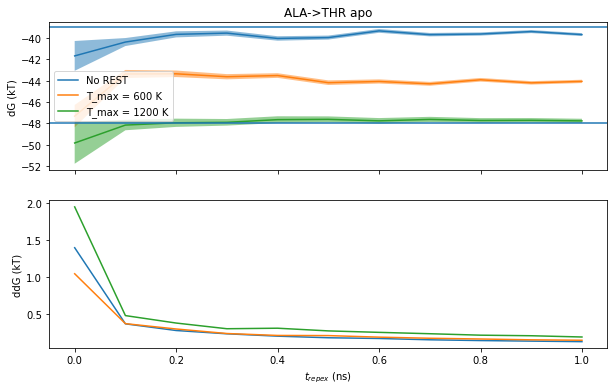

In [48]:
plot_series(d_results, 'apo', 'ALA->THR')